In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
def load_data(dir_name = 'plates'):
    """ Your implementation """
    img_array = []
    for i in os.listdir('plates/'):
        img = mpimg.imread('plates/{}'.format(i))
        img_array.append( img )
    return img_array

plates = load_data()

The dataset is a list of 2-dimensional arrays.

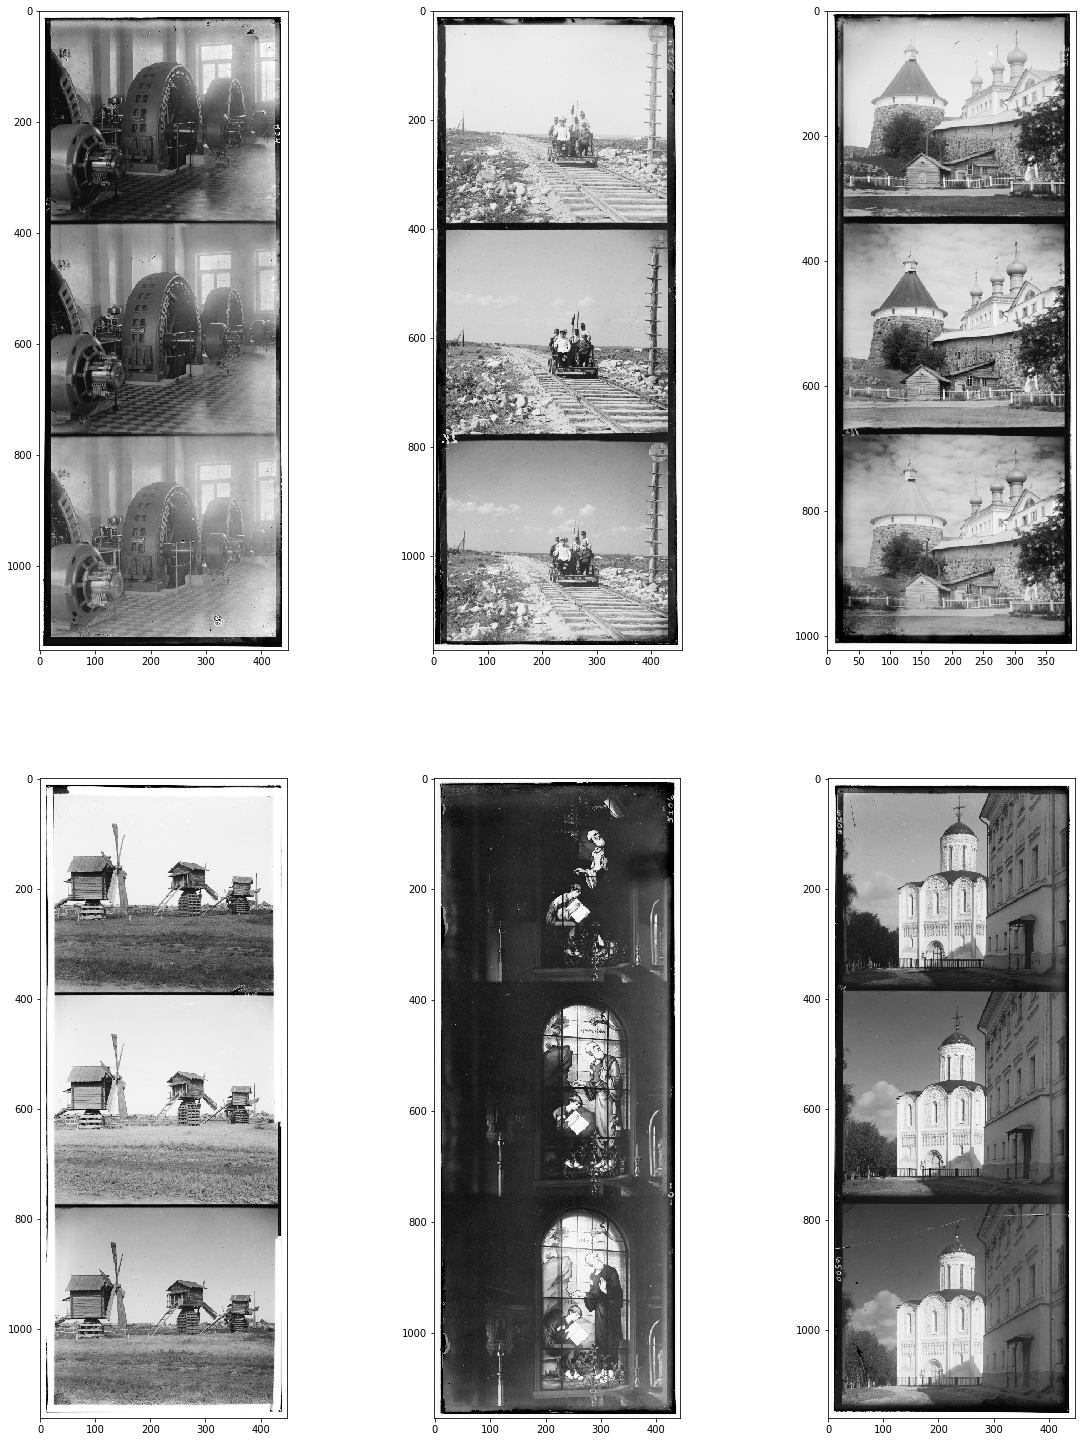

In [5]:
# The auxiliary function `visualize()` displays the images given as argument.
# let's see what the images plates array holds
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

visualize(plates, 'gray')

In [6]:
# our kernel for sobel operations
kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

## GAUSSIAN BLUR

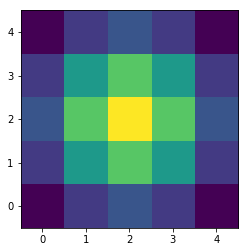

In [9]:
# our gaussian kernel for blur operation
size = 5
x0, y0, sigma = int(size/2),int(size/2),1.4
x, y = np.arange(size), np.arange(size)
gx = np.exp(-(x-x0)**2/(2*sigma**2))
gy = np.exp(-(y-y0)**2/(2*sigma**2))
g = np.outer(gx, gy)
g /= np.sum(g)  # normalize, if you want that
plt.imshow(g, interpolation="nearest", origin="lower")
plt.show()

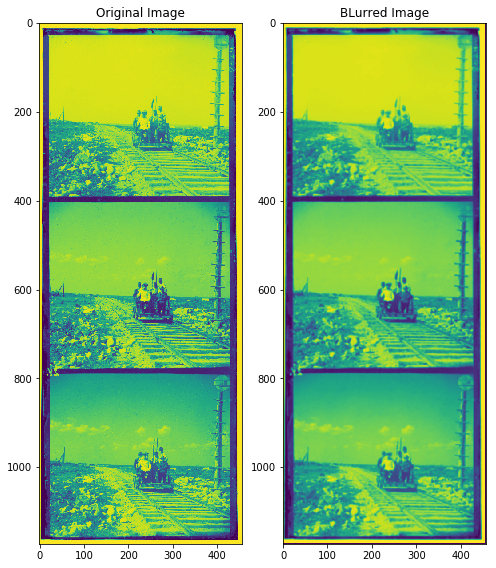

In [11]:
def blur(img_n= 1,g = g):
    img = (plates[img_n].transpose(2,0,1)[0] + plates[img_n].transpose(2,0,1)[1] + plates[img_n].transpose(2,0,1)[2])/3
    pad_blur = g.shape[0] - 2
    dummy_x = np.zeros(shape = img.shape)
    
    row_a,row_b = int(g.shape[0]/2) , img.shape[0]+ 1
    col_a,col_b = int(g.shape[0]/2) , img.shape[1]+1
    
    zeroes = np.zeros(shape=(img.shape[0]+ g.shape[0]-1 ,img.shape[1]+g.shape[0]-1))
    zeroes[row_a:row_b + row_a-1 , col_a:col_b + col_a -1 ] = img.copy()
    
    for row in range( row_a,row_b):
        for col in range( col_a,col_b):
            valx = np.multiply( zeroes[row-row_a:row + row_a+1  ,col-col_a:col+col_a+1] , g )
            dummy_x[row-pad_blur,col-pad_blur] = np.sum(valx)
    return img,dummy_x

orig,blurred = blur(img_n=1)

plt.figure(figsize=(8,16))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(orig)
plt.subplot(1,2,2)
plt.title('BLurred Image')
plt.imshow(blurred)

In [70]:
def gardient(img = blurred, img_n= None,kernel_x= kx,kernel_y = ky):
    if img_n is not None:
        img = (plates[img_n].transpose(2,0,1)[0] + plates[img_n].transpose(2,0,1)[1] + plates[img_n].transpose(2,0,1)[2])/3
    pad_blur = kx.shape[0] - 2
    dummy_x = np.zeros(shape = img.shape)
    dummy_y = np.zeros(shape = img.shape)
    
    row_a,row_b = int(kx.shape[0]/2) , img.shape[0]+ 1
    col_a,col_b = int(kx.shape[0]/2) , img.shape[1]+1
    
    zeroes = np.zeros(shape=(img.shape[0]+ kx.shape[0]-1 ,img.shape[1]+kx.shape[0]-1))
    zeroes[row_a:row_b + row_a-1 , col_a:col_b + col_a -1 ] = img.copy()
    print(row_a,row_b)
    for row in range( row_a,row_b):
        for col in range( col_a,col_b):
            valx = np.multiply( zeroes[row-row_a:row + row_a+1  ,col-col_a:col+col_a+1] , kernel_x)
            dummy_x[row-pad_blur,col-pad_blur] = np.sum(valx)
            valy = np.multiply( zeroes[row-row_a:row + row_a+1  ,col-col_a:col+col_a+1] , kernel_y )
            dummy_y[row-pad_blur,col-pad_blur] = np.sum(valy)
    
    
    return img,dummy_x,dummy_y

orig,dummy_x,dummy_y = gardient()
grad_img = np.sqrt(np.square(dummy_x)+ np.square(dummy_y))

1 1174


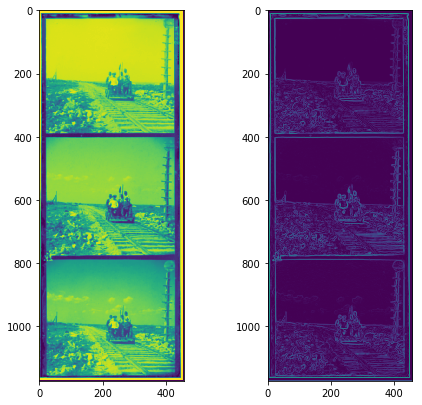

In [71]:
plt.figure(figsize=(7.5,15))
plt.subplot(2,2,1)
plt.imshow(orig)
plt.subplot(2,2,2)
plt.imshow(grad_img)

In [77]:
direction = np.arctan2(dummy_y,dummy_x)
direction = direction * 180. / np.pi
direction[direction < 0] += 180
## convert all to range 0-180
##now, round off to nearest range
direction[direction < 22.5] = 0
direction[direction > 157.5] = 0
direction[(direction > 67.5 ) & (direction < 112.5)] = 90
direction[(direction > 22.5 ) & (direction < 67.5)] = 45
direction[(direction < 157.5 ) & (direction > 112.5)] = 135
direction = direction.astype(int)

## Non max supression

In [80]:
def ang_rc(angle,r,c):
    if angle == 0 :
        return r,c-1,r,c+1
    elif angle == 45: 
        return r+1,c-1,r-1,c+1
    elif angle == 90:
        return r-1,c,r+1,c
    elif angle == 135:
        return r-1,c-1,r+1,c+1
    
def non_max_surpress(grad_img,direction):
    paded_magnitude = np.pad(grad_img, pad_width=1, mode='constant')
    row,col = direction.shape
    dummy_surpressed = np.zeros(shape= direction.shape)
    for r in range(row):
        for c in range(col):
            angle = direction[r,c]
            magnitude = grad_img[r,c]
            r1,c1,r2,c2 = ang_rc(angle,r+1,c+1)
            condition = magnitude > paded_magnitude[r1,c1] and magnitude > paded_magnitude[r2,c2] 
            if condition :
                dummy_surpressed[r,c] = grad_img[r,c]
            else :
                dummy_surpressed[r,c] = 0
    return dummy_surpressed
dummy_surpressed = non_max_surpress(grad_img,direction)

## HYSTERESIS EDGE

In [82]:
strong = 255
weak = 80
def thres(dummy_surpressed = dummy_surpressed.copy()):
    high_thres = np.max(dummy_surpressed) * 0.48
    low_thres = np.max(dummy_surpressed) * 0.18
    # strong pixels
    dummy_surpressed[dummy_surpressed >= high_thres ] = strong
    # weak pixels
    dummy_surpressed[(dummy_surpressed < high_thres) & (dummy_surpressed >= low_thres)] = weak
    # irrelevant pixels
    dummy_surpressed[dummy_surpressed < low_thres ] = 0
    return dummy_surpressed.astype(int)

In [87]:
def hystereris_edge(grad_img= thres(),weak_val= weak,strong_val = strong):
    row,col = direction.shape
#     edged = np.zeros(shape= direction.shape)
    
    for r in range(1,row-1):
        for c in range(1,col-1):
            if grad_img[r,c] == weak_val :
                window = grad_img[r-1:r+2,c-1:c+2]
                if np.any(np.isin(window,[weak_val])):
                    grad_img[r,c] = strong_val
                else :
                    grad_img[r,c] = 0
    return grad_img

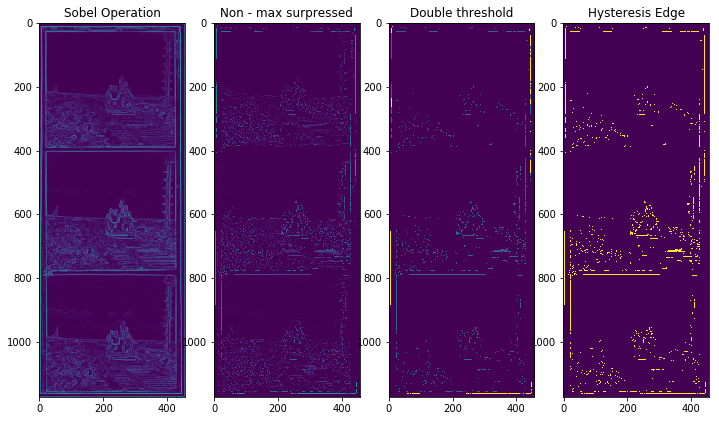

In [88]:
plt.figure(figsize=(12,40))
plt.subplot(1,4,1)
plt.title('Sobel Operation')
plt.imshow(grad_img)
plt.subplot(1,4,2)
plt.title('Non - max surpressed')
plt.imshow(dummy_surpressed)
## apply double threshold, 0.09, 0.05 are our
## supplied parameters
plt.subplot(1,4,3)
plt.title('Double threshold')
plt.imshow(thres())

plt.subplot(1,4,4)
plt.title('Hysteresis Edge')
plt.imshow(hystereris_edge())
